二元分类器在两个类中区分，而多类分类器（也称为多项分类器）可以区分两个以上的类。有一些算法（如随机森林分类器或朴素贝叶斯分类器）可以直接处理多个类。也有一些严格的二元分类器（如支持向量机分类器或线性分类器）。但是，有多种策略可以让你用几个二元分类器实现多类分类的目的。

我们这里使用的是mnist数据集。


**OVR**
要创建一个系统将数字图片分为10类（从0到9），一种方法是训练10个二元分类器，每个数字一个（0检测器、1检测器、2检测器，以此类推）。然后，当你需要对一张图片进行检测分类时，获取每个分类器的决策分数，哪个分类器给分最高，就将其分为哪个类。这称为一对剩余（OvR）策略，也称为一对多（oneversusall）。


**OVO**
另一种方法是为每一对数字训练一个二元分类器：一个用于区分0和1，一个区分0和2，一个区分1和2，以此类推。这称为一对一（OvO）策略。如果存在N个类别，那么这需要训练N×（N1）/2个分类器。对于MNIST问题，这意味着要训练45个二元分类器！当需要对一张图片进行分类时，你需要运行45个分类器来对图片进行分类，最后看哪个类获胜最多。OvO的主要优点在于，每个分类器只需要用到部分训练集对其必须区分的两个类进行训练。

有些算法（例如支持向量机分类器）在数据规模扩大时表现糟糕。对于这类算法，OvO是一个优先的选择，因为在较小训练集上分别训练多个分类器比在大型数据集上训练少数分类器要快得多。但是对大多数二元分类器来说，OvR策略还是更好的选择。ScikitLearn可以检测到你尝试使用二元分类算法进行多类分类任务，它会根据情况自动运行OvR或者OvO。我们用sklearn.svm.SVC类来试试SVM分类器：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 二分类模型

我们先准备好数据：

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X,y = mnist['data'], mnist['target']

X_train, X_test = X[:6000], X[6000:]
y_train, y_test = y[:6000].astype(np.uint8), y[6000:].astype(np.uint8)

数据准备好了，我们开始训练模型：

In [3]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

OK，模型训练好了，我们预测几个数据：


In [7]:
svm_clf.predict([X[0], X[1]])

array([5, 0], dtype=uint8)

In [8]:
print(y[0], y[1])

5 0


完美，预测正确。

这段代码使用原始目标类0到9（y_train）在训练集上对SVC进行训练，而不是以“5”和“剩余”作为目标类（y_train_5），然后做出预测（在本例中预测正确）。而在内部，ScikitLearn实际上训练了45个二元分类器，获得它们对图片的决策分数，然后选择了分数最高的类。

要想知道是不是这样，可以调用decision_function（）方法。它会返回10个分数，每个类1个，而不再是每个实例返回1个分数



In [11]:
some_scores = svm_clf.decision_function([X[1]])
print(some_scores)

[[ 9.31124939  0.70612005  6.21459611  4.98107511 -0.29750684  8.27747974
   3.82932284  1.74975607  3.81848706  6.05566815]]


我们可以看出，第0个结果的分数最高，所以分类结果为0。

如果想要强制ScikitLearn使用一对一或者一对剩余策略，可以使用OneVsOneClassifier或OneVsRestClassifier类。只需要创建一个实例，然后将分类器传给其构造函数（它甚至不必是二元分类器）。

In [12]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([X[0]])

array([5], dtype=uint8)

## 多分类模型
上述方式使用的是一个二分类模型来计算多分类问题，我们也可以直接使用SGDClassifier, RandomForestClassifer等可用于多分类的模型：

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([5], dtype=uint8)

我们看一下分数：

In [17]:
sgd_clf.decision_function([X[0]])

array([[-562212.94461254, -707645.64712029, -293553.98530211,
         -55603.9170907 , -842804.94696506,   41561.46574389,
        -642257.63484493, -793582.58056233, -381185.27236082,
        -359218.48451935]])

模型好像相当自信，除了5以为，其它score都是负数。

我们再看一下准确率：

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8595, 0.868 , 0.8625])

所有的测试折叠上都超过了85%。如果是一个纯随机分类器，准确率大概是10%，所以这个结果不是太糟，但是依然有提升的空间。例如，将输入进行简单缩放可以将准确率稍为提高：

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaler, y_train, cv=3, scoring='accuracy')

array([0.867, 0.898, 0.889])

## 多分类问题的误差分析

首先看看混淆矩阵。就像之前做的，使用cross_val_predict()函数进行预测，然后调用confusion_matrix（）函数：

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaler, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_pred)
print(confusion_matrix)

[[570   0   3   2   1  11   3   0   2   0]
 [  0 633   8   2   1   6   0   1  18   2]
 [ 10   8 499  10   9   4  11   9  18   3]
 [  3   5  21 512   1  36   1   8  11  10]
 [  4   2   8   0 557   2   9   7  10  24]
 [  5   6   5  25  14 411  10   1  24  13]
 [  4   4   6   0   5   7 578   1   3   0]
 [  3   5   9   3  10   0   1 575   2  43]
 [  3  18  14  17   4  10   8   3 461  13]
 [  7   4   6   8  17   3   0  29   8 519]]


我们可以看到数字主要集中在对角线，说明效果还是比较理想的。

我们使用更直观的图线方式来看一下混淆矩阵：

<function matplotlib.pyplot.show(close=None, block=None)>

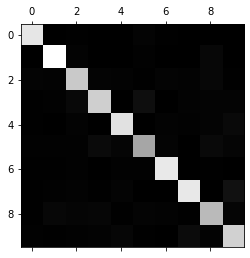

In [33]:
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show

数字5看起来暗一点，这以为着数据集中被判断为5的照片比较少，有可能是5真的少，也有可能我们把5分到了其它类。所以我们看一下错误率：

In [35]:
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
nor_conf_mx = confusion_matrix / row_sums

用0填充对角线，只保留错误：

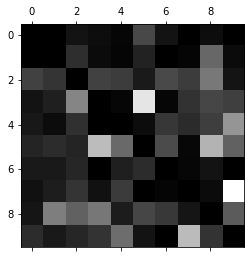

In [38]:
np.fill_diagonal(nor_conf_mx, 0)
plt.matshow(nor_conf_mx, cmap=plt.cm.gray)
plt.show()

现在可以清晰地看到分类器产生的错误种类了。记住，每行代表实际类，而表示预测类。第5列看起来非常亮，说明有许多图片被错误地分类为数字5了。

分析混淆矩阵通常可以帮助你深入了解如何改进分类器。通过上图来看，你的精力可以花在改进数字5的分类错误上。例如，可以试着收集更多看起来像数字8的训练数据，以便分类器能够学会将它们与真实的数字区分开来。

反正，发现问题后，你可以通过各种方式来解决这个问题，比如检查样本，把样本一个一个打印出来。你可能发现样本中的3和5非常类型。毕竟我们这里使用的是线性分类器，一些写的不规范的3和5很容易被混淆。